# Neural Style Transfer

## Importing Packages and Selecting Device

In [87]:
import torch
import torch.nn as nn            # for implementaing neural network
import torch.nn.functional as F  # for operations such s convolutional, activation functions, pooling and loss calculation
import torch.optim as optim      # for optimization algorithm

from PIL import Image            # for image related task open, close
import matplotlib.pyplot as plt  # visualization

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [88]:
# for device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Loading Images

In [89]:
imsize = 128 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),    # scale imported image
    transforms.ToTensor()         # transforms it to torch tensor
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # fake batch dimension required to fit network's input dimension
    return image.to(device, torch.float)

In [90]:
imsize

128

In [91]:
style_img = Image.open('style.png')
style_img = style_img.convert('RGB')
style_img.save('style.png')

content_img = Image.open('content.png')
content_img = content_img.convert('RGB')
content_img.save('content.png')

In [92]:
style_img = image_loader("style.png")
content_img = image_loader("content.png")
assert style_img.size() == content_img.size()  # we need to import content ans style images of same size

In [93]:
print(content_img.size())
print(style_img.size())

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


In [94]:
unloader = transforms.ToPILImage()   # reconvert into PIL image
plt.ion()                            # enables interactive mode for plot

def show_img(tensor, title=None):
    image = tensor.cpu().clone()     # avoids unintentional modification while displaying
    image = image.squeeze(0)         # remove fake batch dimension
    image = unloader(image)
    #plt.figure(figsize=(1.28, 1.28), dpi=100)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)                 # pause a bit so that plots are update

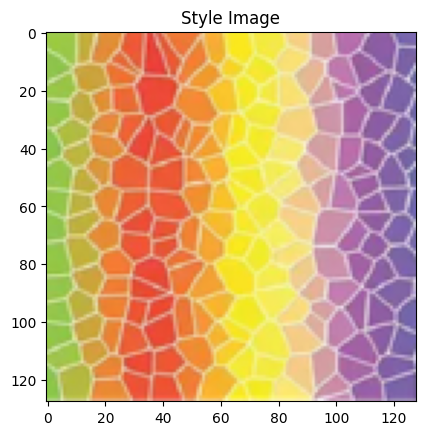

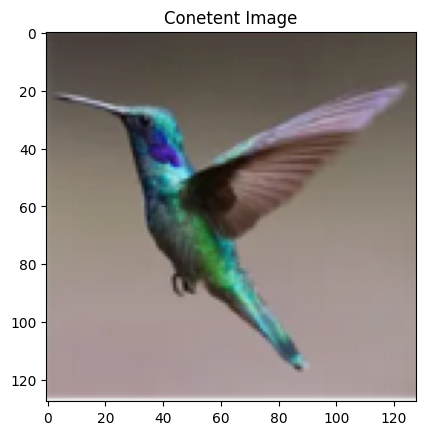

In [95]:
plt.figure()            # to create a new figure for our plot
show_img(style_img, title="Style Image")

plt.figure()
show_img(content_img, title="Conetent Image")

## Loss Function

### Content Loss

In [96]:
class ContentLoss(nn.Module):                # inheriate from parent class nn.Module
    def __init__(self, target):              # target = feature maps of the content image
        super(ContentLoss, self).__init__()
        self.target = target.detach()        # ensure content image remains fixed during optimization

    def forward(self, input):                # input = feature maps of generated image
        self.loss = F.mse_loss(input, self.target)
        return input                         # allowing subsequent layers to process the original features

### Style Loss

In [97]:
def gram_matrix(input):
    a, b, c, d = input.size()
    """
     a = batch size(=1)
     b = number of feature maps
     (c,d) = dimensions of features maps
    """

    features = input.view(a*b, c*d)       # reshape the features maps
    G = torch.mm(features, features.t())  # gram matrix

    return G.div(a*b*c*d)

In [98]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):        # target_feature = feature map of style image
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


## Importing Model

In [99]:
"""
    Here vgg19 model is used for features extraction only no need
    of FC layers. And model must be on evaluation mode only because
    here we are not optimizing the model. eval() disables dropout
    and batch normalization
"""
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [100]:
# model architecture / summary
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [101]:
"""
  VGG networks are trained on images with each channel normalized by mean=[0.485,0.456,0.406] and
  std=[0.229,0.224,0.225]. We will use them to normalize the image before sending it into the network.
  ensuring reliable and accurate performance
"""
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [102]:
# module to normalize the input image
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)

    def forward(self, img):
        return (img-self.mean)/self.std

In [103]:
# normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)
# model = nn.Sequential(normalization)
# model

In [104]:
# for layer in cnn.children():
#     if isinstance(layer, nn.Conv2d):
#         print(layer)

In [105]:
# i = 10
# name = "conv_{}".format(i)
# print(name)

In [106]:
#i = 0
#for layer in cnn.children():
#    if isinstance(layer, nn.Conv2d):
#        i+=1
#        name = "Conv_{}".format(i)
#        model.add_module(name, layer)
#model

In [107]:
#for i in range(len(model) -1, -1, -1):
#    print(i)

In [108]:
#model[2]

In [109]:
#content_layers_default = ['conv_4', 'conv_10']
#style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
#for name in content_layers_default:
#    target = model(content_img).detach()

In [110]:
content_layers_default = ['conv_10', 'conv_15']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9']

def get_style_model_and_losses(cnn, normalization_mean,
                               normalization_std, style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    #losses
    content_losses = []
    style_losses = []

    # to put in module that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+=1
            name='conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name='pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognozed layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            """
              .detach() method in pytorch is used to create a new tensor that is disconnect
              from the current computational and will not track gradient and not participate
              in backpropagation
            """
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) -1, -1, -1):       # range(start, stop, step)
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i+1)]

    return model, style_losses, content_losses

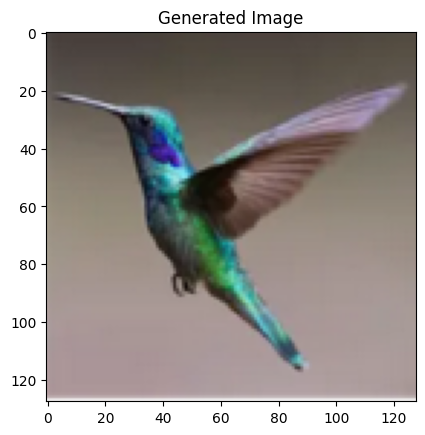

In [111]:
generated_img = content_img.clone()
plt.figure()

show_img(generated_img, title="Generated Image")

## Gradient Descent

In [112]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [113]:
def NST(cnn, normalization_mean, normalization_std,
        content_img, style_img, input_img, num_steps=600,
        style_weight=1000, content_weight=1):
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                     normalization_std, style_img,
                                                                     content_img)
    input_img.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing--')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0,1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0]+=1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print("Style Loss: {:4f} Content Loss: {:4f}".format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

## Output

Building the style transfer model..
Optimizing--
run [100]:
Style Loss: 45.930012 Content Loss: 62.804558

run [200]:
Style Loss: 43.627655 Content Loss: 58.234589

run [300]:
Style Loss: 42.731960 Content Loss: 56.575207

run [400]:
Style Loss: 42.082130 Content Loss: 55.768356

run [500]:
Style Loss: 41.802814 Content Loss: 55.036003

run [600]:
Style Loss: 41.603043 Content Loss: 54.454655



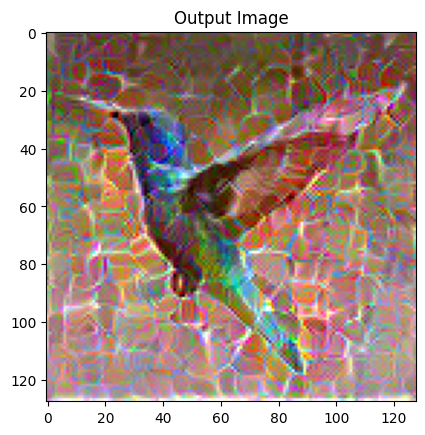

In [114]:
output = NST(cnn, normalization_mean = cnn_normalization_mean,
             normalization_std = cnn_normalization_std,
             content_img = content_img, style_img = style_img,
             input_img = generated_img)
plt.figure()
show_img(output, title="Output Image")

plt.ioff()
plt.show()